# Olympian deities

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

np.random.seed(42)

## Load dataset

Javascript code to download images from DuckDuckGo:

```javascript
urls=Array.from(document.querySelectorAll('.tile--img__img')).map(el=>el.hasAttribute('data-src')?el.getAttribute('src'):el.getAttribute('data-src')).filter(l=>l!=null).map(l=>'https:'+l).join('\n')
```

In [14]:
dataset = Path("datasets/ddg_images")
imgurl = Path("imgurls/ddg_images")

In [15]:
dataset.ls()

[PosixPath('datasets/ddg_images/poseidon'),
 PosixPath('datasets/ddg_images/zeus'),
 PosixPath('datasets/ddg_images/artemis'),
 PosixPath('datasets/ddg_images/aphrodite'),
 PosixPath('datasets/ddg_images/athena'),
 PosixPath('datasets/ddg_images/hestia'),
 PosixPath('datasets/ddg_images/hermes'),
 PosixPath('datasets/ddg_images/hera'),
 PosixPath('datasets/ddg_images/demeter'),
 PosixPath('datasets/ddg_images/apollo'),
 PosixPath('datasets/ddg_images/dionysus'),
 PosixPath('datasets/ddg_images/ares')]

In [18]:
imgurl.ls()

[PosixPath('imgurls/ddg_images/artemis.txt'),
 PosixPath('imgurls/ddg_images/poseidon.txt'),
 PosixPath('imgurls/ddg_images/athena.txt'),
 PosixPath('imgurls/ddg_images/hermes.txt'),
 PosixPath('imgurls/ddg_images/ares.txt'),
 PosixPath('imgurls/ddg_images/hera.txt'),
 PosixPath('imgurls/ddg_images/zeus.txt'),
 PosixPath('imgurls/ddg_images/aphrodite.txt'),
 PosixPath('imgurls/ddg_images/apollo.txt'),
 PosixPath('imgurls/ddg_images/demeter.txt'),
 PosixPath('imgurls/ddg_images/hestia.txt'),
 PosixPath('imgurls/ddg_images/dionysus.txt')]

In [21]:
classes = [p.stem for p in imgurl.ls()]
classes

['artemis',
 'poseidon',
 'athena',
 'hermes',
 'ares',
 'hera',
 'zeus',
 'aphrodite',
 'apollo',
 'demeter',
 'hestia',
 'dionysus']

In [24]:
for c in classes:
    download_images(f"{imgurl/c}.txt", dataset / c)

In [43]:
for c in classes:
    verify_images(dataset / c, delete=True, max_size=600)

## View data

In [59]:
# data = ImageDataBunch.from_folder(
#     dataset,
#     train=".",
#     valid_pct=0.2,
#     ds_tfms=get_transforms(),
#     size=224,
#     num_workers=4,
# ).normalize(imagenet_stats)

# use cleaned up data
data = ImageDataBunch.from_csv(
    dataset,
    csv_labels="cleaned.csv",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
).normalize(imagenet_stats)

In [62]:
data.c, data.classes, len(data.train_ds), len(data.valid_ds)

(12,
 ['aphrodite',
  'apollo',
  'ares',
  'artemis',
  'athena',
  'demeter',
  'dionysus',
  'hera',
  'hermes',
  'hestia',
  'poseidon',
  'zeus'],
 5282,
 1320)

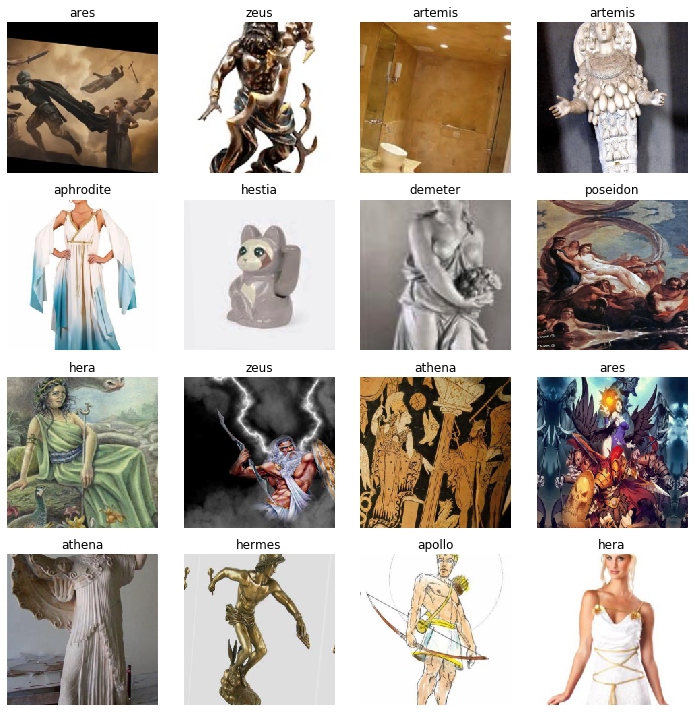

In [66]:
data.show_batch(rows=4, figsize=(10, 10))

## Training: Resnet34

In [67]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [68]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.953348,1.764237,0.568182,00:39
1,2.235693,1.453664,0.455303,00:38
2,1.766436,1.286503,0.403788,00:38
3,1.511545,1.183358,0.359091,00:39
4,1.333683,1.066022,0.324242,00:39
5,1.202663,1.049744,0.321212,00:39
6,1.094075,1.012639,0.312121,00:39
7,1.018425,1.013754,0.311364,00:39


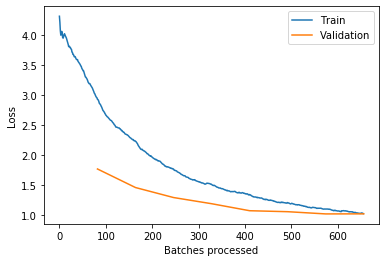

In [69]:
learn.recorder.plot_losses()

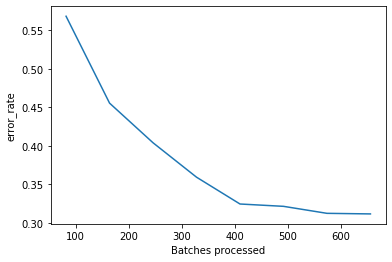

In [70]:
learn.recorder.plot_metrics()

In [71]:
learn.save("stage-1")

### Unfreezing

In [72]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


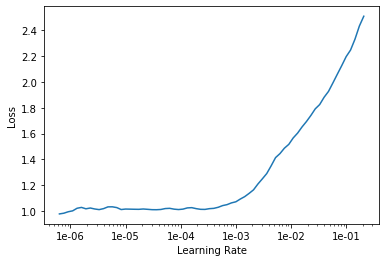

In [73]:
learn.lr_find()
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(5, max_lr=slice(6e-6, 6e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.995528,0.982649,0.296212,00:55
1,0.957824,0.929439,0.275000,00:55
2,0.866429,0.890168,0.265152,00:55
3,0.800866,0.875971,0.256818,00:55
4,0.744338,0.864573,0.255303,00:55


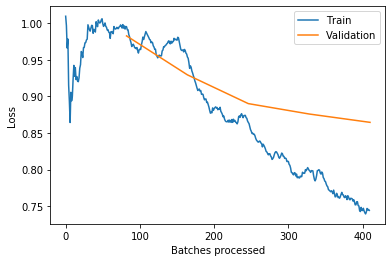

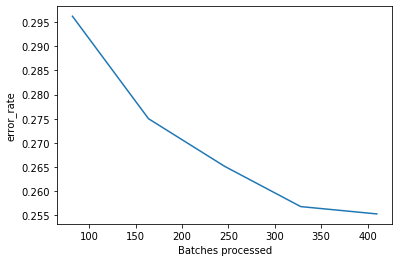

In [75]:
learn.recorderecorderecorderrderrder.plot_losses()
learn.recorder.plot_metrics()

In [76]:
learn.save("stage-2")

## Training: ResNet50

In [ ]:
data = ImageDataBunch.from_folder(
    dataset,
    train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
    bs=32,
).normalize(imagenet_stats)

In [74]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.228268,1.673340,0.511029,00:20
1,1.940508,1.957797,0.544118,00:19
2,1.628304,1.424840,0.488971,00:19
3,1.340127,1.146965,0.408088,00:19
4,1.064277,1.138120,0.433824,00:19
5,0.897164,1.132800,0.426471,00:19
6,0.776726,1.050517,0.408088,00:19
7,0.700976,1.041349,0.411765,00:19


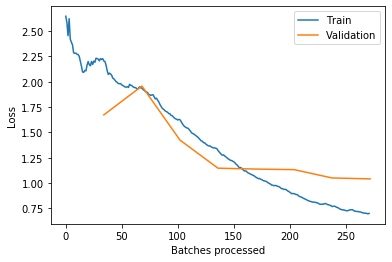

In [77]:
learn.recorder.plot_losses()

In [78]:
learn.save("stage-1-50")

## Interpretation

In [77]:
learn.load("stage-2")
interp = ClassificationInterpretation.from_learner(learn)

[('aphrodite', 'demeter', 13), ('apollo', 'dionysus', 10), ('hera', 'aphrodite', 9), ('athena', 'ares', 8), ('zeus', 'poseidon', 8), ('aphrodite', 'hestia', 7), ('apollo', 'artemis', 7), ('aphrodite', 'artemis', 6), ('artemis', 'hermes', 6), ('athena', 'aphrodite', 6), ('demeter', 'dionysus', 6), ('hestia', 'aphrodite', 6), ('apollo', 'ares', 5), ('apollo', 'athena', 5), ('demeter', 'athena', 5), ('demeter', 'hera', 5), ('dionysus', 'demeter', 5), ('hera', 'hestia', 5), ('zeus', 'hermes', 5)]


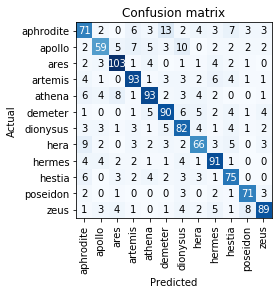

In [85]:
print(interp.most_confused(min_val=5))
interp.plot_confusion_matrix()

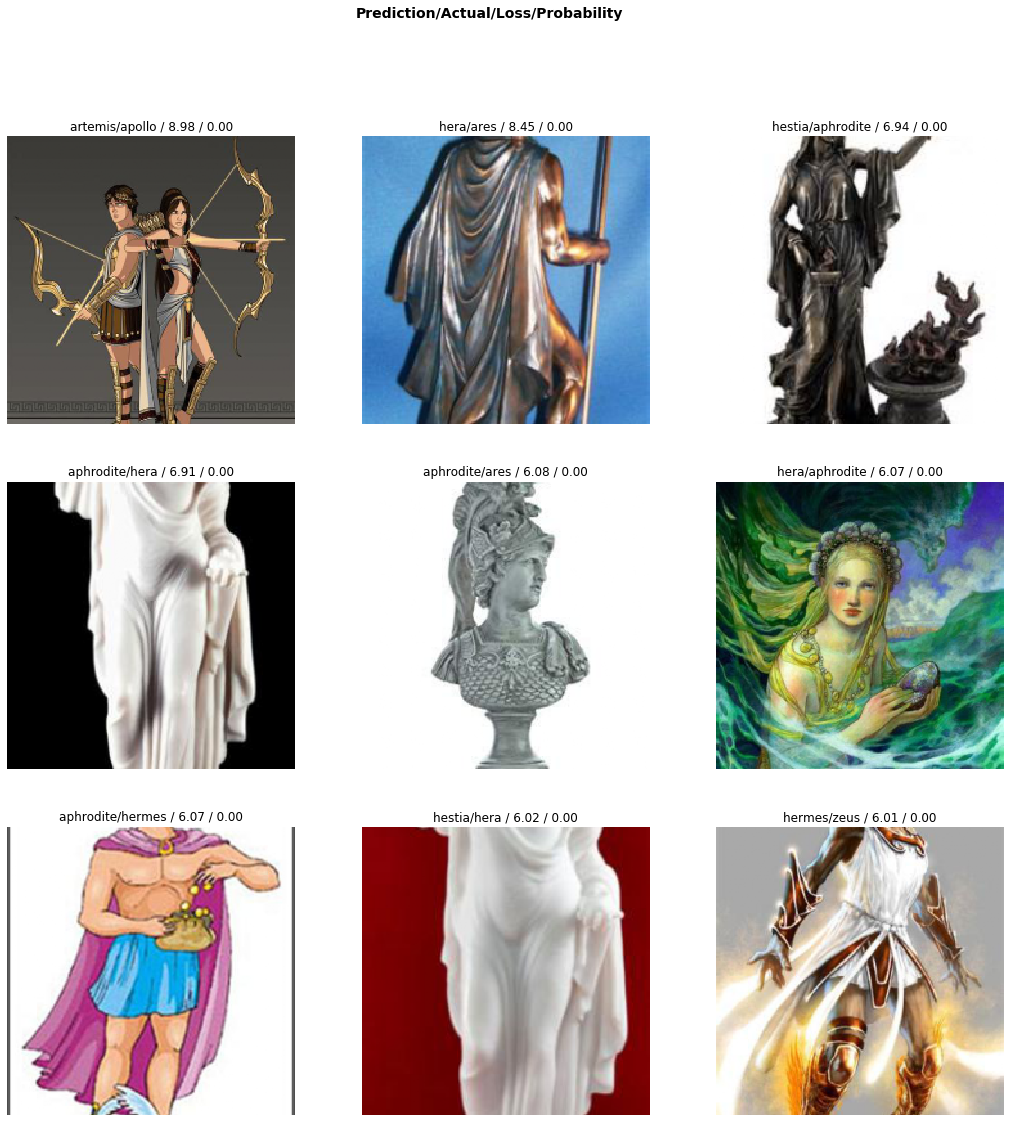

In [86]:
interp.plot_top_losses(9, figsize=(18, 18))

## Data cleaning

In [47]:
from fastai.widgets import *

In [48]:
data = ImageDataBunch.from_folder(
    dataset,
    train=".",
    valid_pct=0,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
    bs=32,
).normalize(imagenet_stats)

In [49]:
learn_clean = cnn_learner(data, models.resnet34, metrics=error_rate)

In [50]:
learn_clean.load("stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (6737 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
poseidon,poseidon,poseidon,poseidon,poseidon
Path: datasets/ddg_images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: datasets/ddg_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [53]:
ds, idxs = DatasetFormatter().from_toplosses(learn_clean)

In [54]:
# DO NOT RUN THIS IN JUPYTER LAB, USE JUPYTER NOTEBOOK
ImageCleaner(ds, idxs, dataset)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [61]:
data = ImageDataBunch.from_csv(
    dataset,
    csv_labels="cleaned.csv",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
).normalize(imagenet_stats)